In [1]:
!pip install transformers
!pip install tensorflow_datasets

In [2]:
import numpy as np
import tensorflow_datasets as tfds
from attention_graph_util import *

import matplotlib.pyplot as plt

plt.rcParams['axes.linewidth'] = 0.0 #set the value globally

In [3]:
import torch
from transformers import (
    BertModel, BertTokenizer,
    OpenAIGPTModel, OpenAIGPTTokenizer,
    GPT2Model, GPT2Tokenizer,
    CTRLModel, CTRLTokenizer,
    TransfoXLModel, TransfoXLTokenizer,
    XLNetModel, XLNetTokenizer,
    XLMModel, XLMTokenizer,
    DistilBertModel, DistilBertTokenizer,
    RobertaModel, RobertaTokenizer,
    BertForPreTraining, 
    BertForMaskedLM, 
    BertForNextSentencePrediction,
    BertForSequenceClassification, 
    BertForTokenClassification, 
    BertForQuestionAnswering
)

# Transformers has a unified API
# for 8 transformer architectures and 30 pretrained weights.
#          Model          | Tokenizer          | Pretrained weights shortcut
MODELS = [(BertModel,       BertTokenizer,       'bert-base-uncased'),
          (OpenAIGPTModel,  OpenAIGPTTokenizer,  'openai-gpt'),
          (GPT2Model,       GPT2Tokenizer,       'gpt2'),
          (CTRLModel,       CTRLTokenizer,       'ctrl'),
          (TransfoXLModel,  TransfoXLTokenizer,  'transfo-xl-wt103'),
          (XLNetModel,      XLNetTokenizer,      'xlnet-base-cased'),
          (XLMModel,        XLMTokenizer,        'xlm-mlm-enfr-1024'),
          (DistilBertModel, DistilBertTokenizer, 'distilbert-base-uncased'),
          (RobertaModel,    RobertaTokenizer,    'roberta-base')]

c:\int_Att\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Each architecture is provided with several class for fine-tuning on down-stream tasks, e.g.
BERT_MODEL_CLASSES = [BertModel, BertForPreTraining, BertForMaskedLM, BertForNextSentencePrediction,
                      BertForSequenceClassification, BertForTokenClassification, BertForQuestionAnswering]

# All the classes for an architecture can be initiated from pretrained weights for this architecture
# Note that additional weights added for fine-tuning are only initialized
# and need to be trained on the down-stream task
pretrained_weights = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(pretrained_weights)

In [5]:
model = BertModel.from_pretrained(pretrained_weights,
                                    output_hidden_states=True,
                                    output_attentions=True)


In [6]:
sentence = "He said his last words"
sentence = "James Cook was a nice person and a good husband"
sentence = "The horse raced past the barn fell"
tokens = ['cls']+tokenizer.tokenize(sentence)+['sep']
print(len(tokens))
input_ids = torch.tensor([tokenizer.encode(sentence)])
all_hidden_states, all_attentions = model(input_ids)[-2:]

_attentions = [att.detach().numpy() for att in all_attentions]
attentions_mat = np.asarray(_attentions)[:,0]
print(attentions_mat.shape)

9
(12, 12, 9, 9)


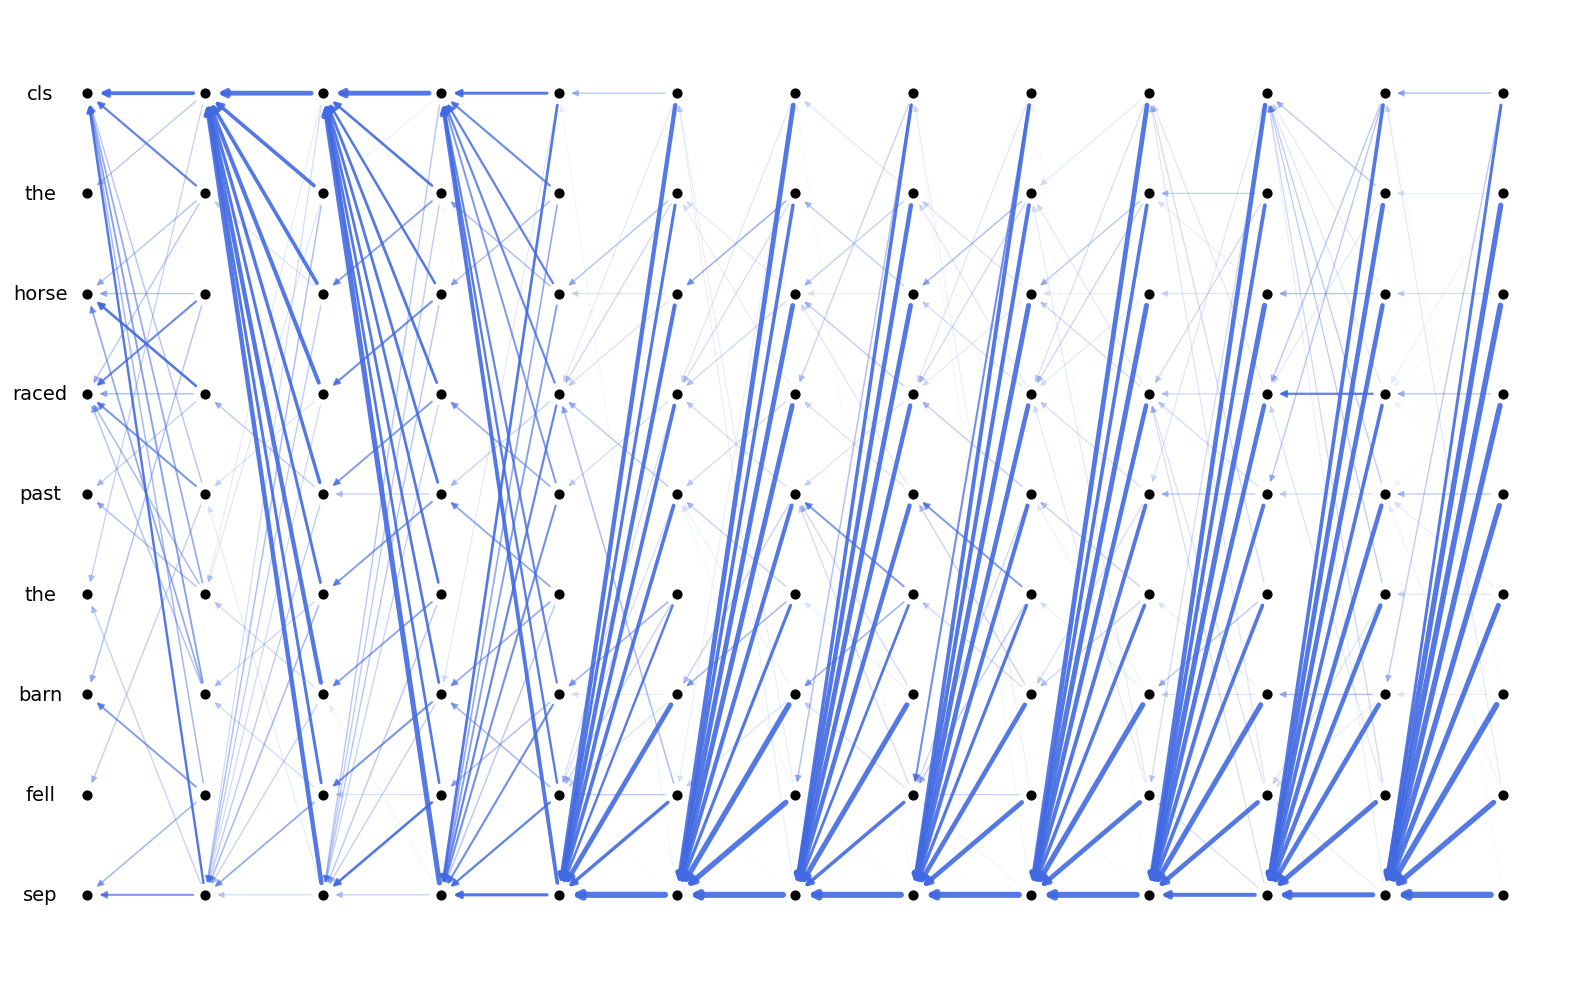

In [7]:
att_mat = attentions_mat.sum(axis=1)/8
adj_mat, labels_to_index = get_adjmat(mat=att_mat, input_tokens=tokens)

G = draw_attention_graph(adj_mat,labels_to_index, n_layers=attentions_mat.shape[0], length=attentions_mat.shape[-1])
plt.savefig('rat_bert.jpg', format='jpg', transparent=True, dpi=760)

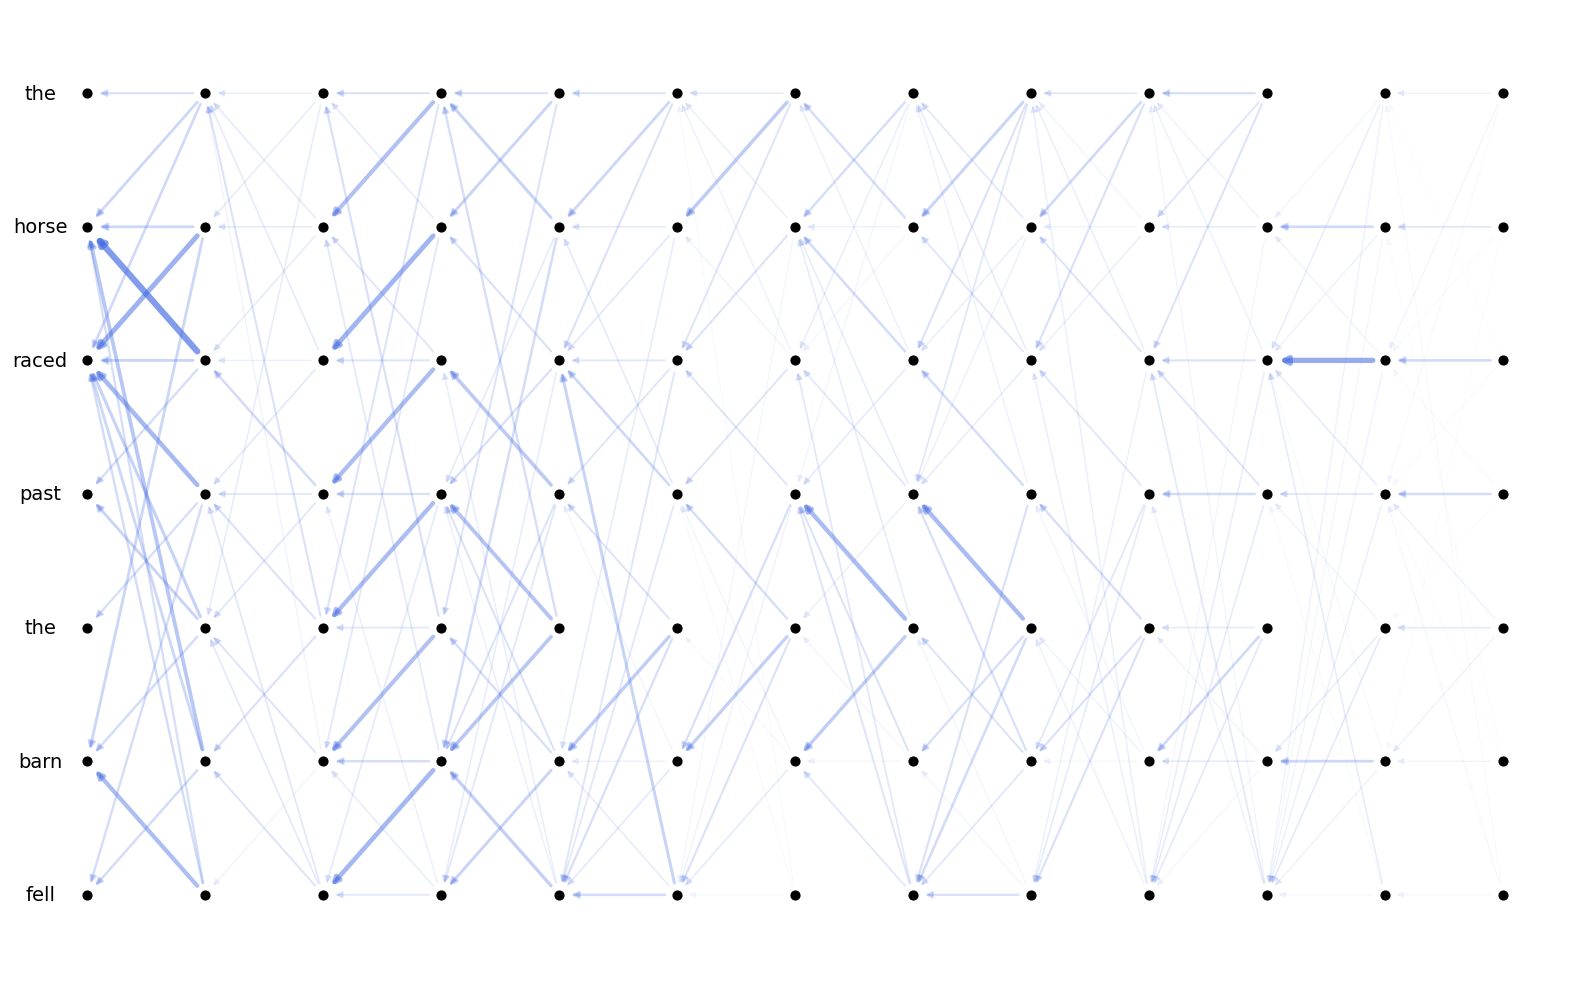

In [8]:
sentence = "The horse raced past the barn fell"

tokens = tokenizer.tokenize(sentence)

encoded = tokenizer.encode(sentence)

input_ids = torch.tensor([encoded])
all_hidden_states, all_attentions = model(input_ids)[-2:]

_attentions = [att.detach().numpy() for att in all_attentions]
attentions_mat = np.asarray(_attentions)[:,0]

attentions_mat = attentions_mat[:, :, 1:-1, 1:-1]

att_mat = attentions_mat.mean(axis=1)
adj_mat, labels_to_index = get_adjmat(mat=att_mat, input_tokens=tokens)

G = draw_attention_graph(adj_mat, labels_to_index, n_layers=attentions_mat.shape[0], length=attentions_mat.shape[-1])
plt.savefig('rat_bert.jpg', format='jpg', transparent=True, dpi=300)

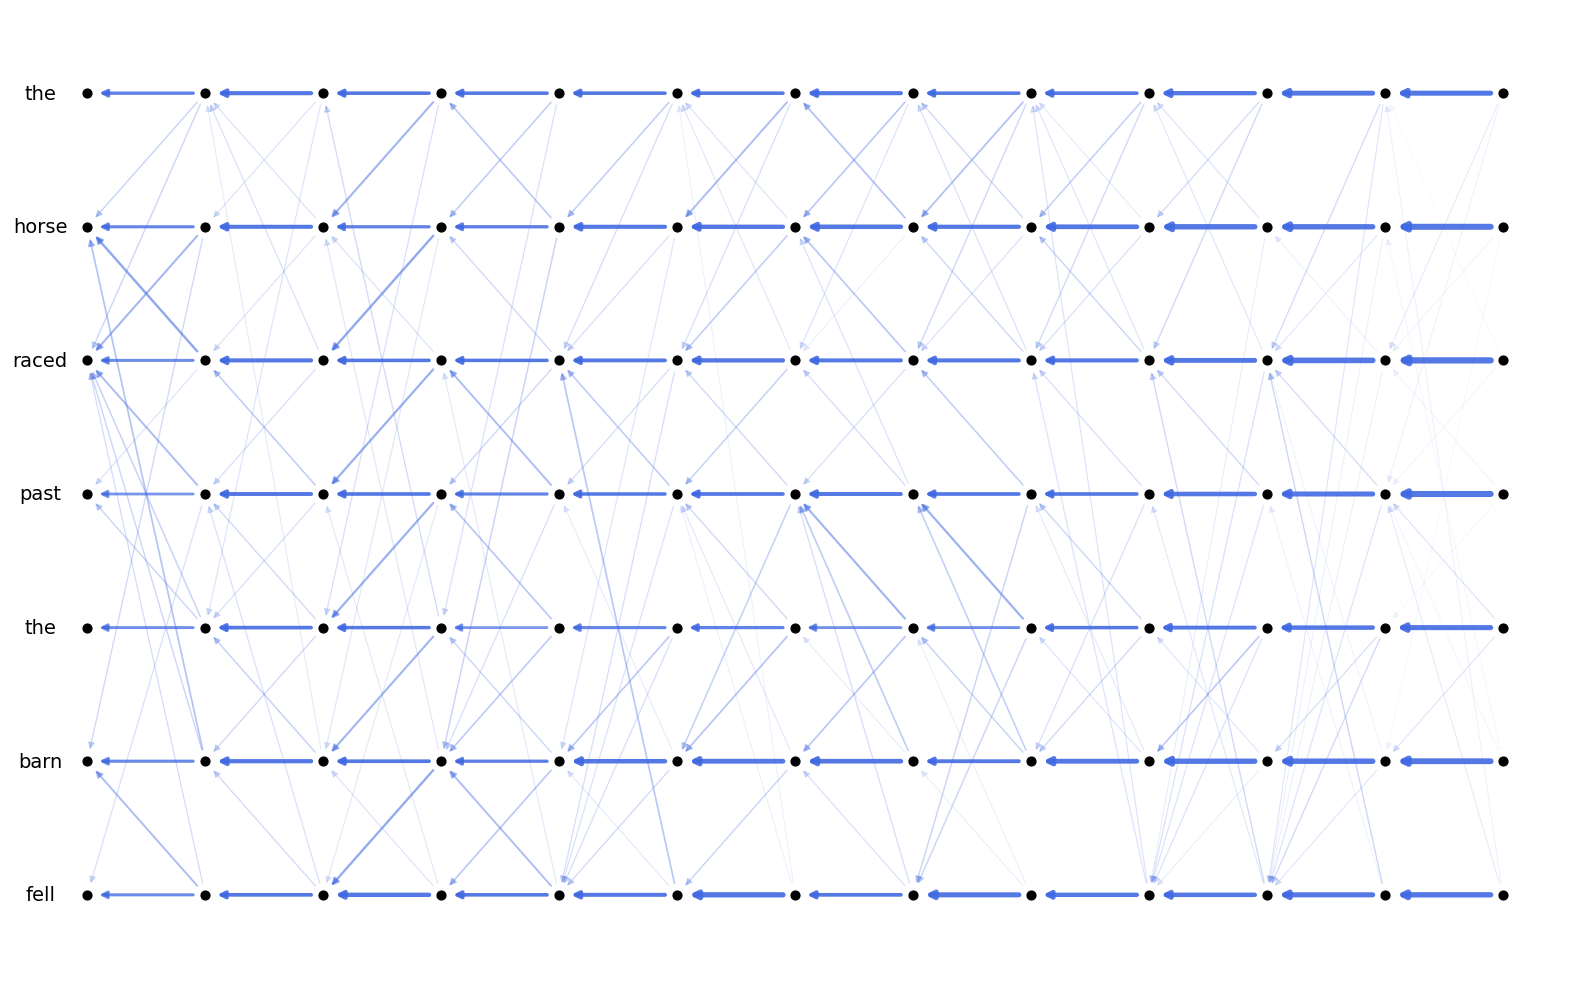

In [9]:
res_att_mat = attentions_mat.sum(axis=1)/12
res_att_mat = res_att_mat + (0.3 * np.eye(res_att_mat.shape[1])[None,...])
res_att_mat = res_att_mat / res_att_mat.sum(axis=-1)[...,None]
 
res_adj_mat, res_labels_to_index = get_adjmat(mat=res_att_mat, input_tokens=tokens)

res_G = draw_attention_graph(res_adj_mat,res_labels_to_index, n_layers=res_att_mat.shape[0], length=res_att_mat.shape[-1])
plt.savefig('res_rat_bert.jpg', format='jpg', transparent=True, dpi=760)

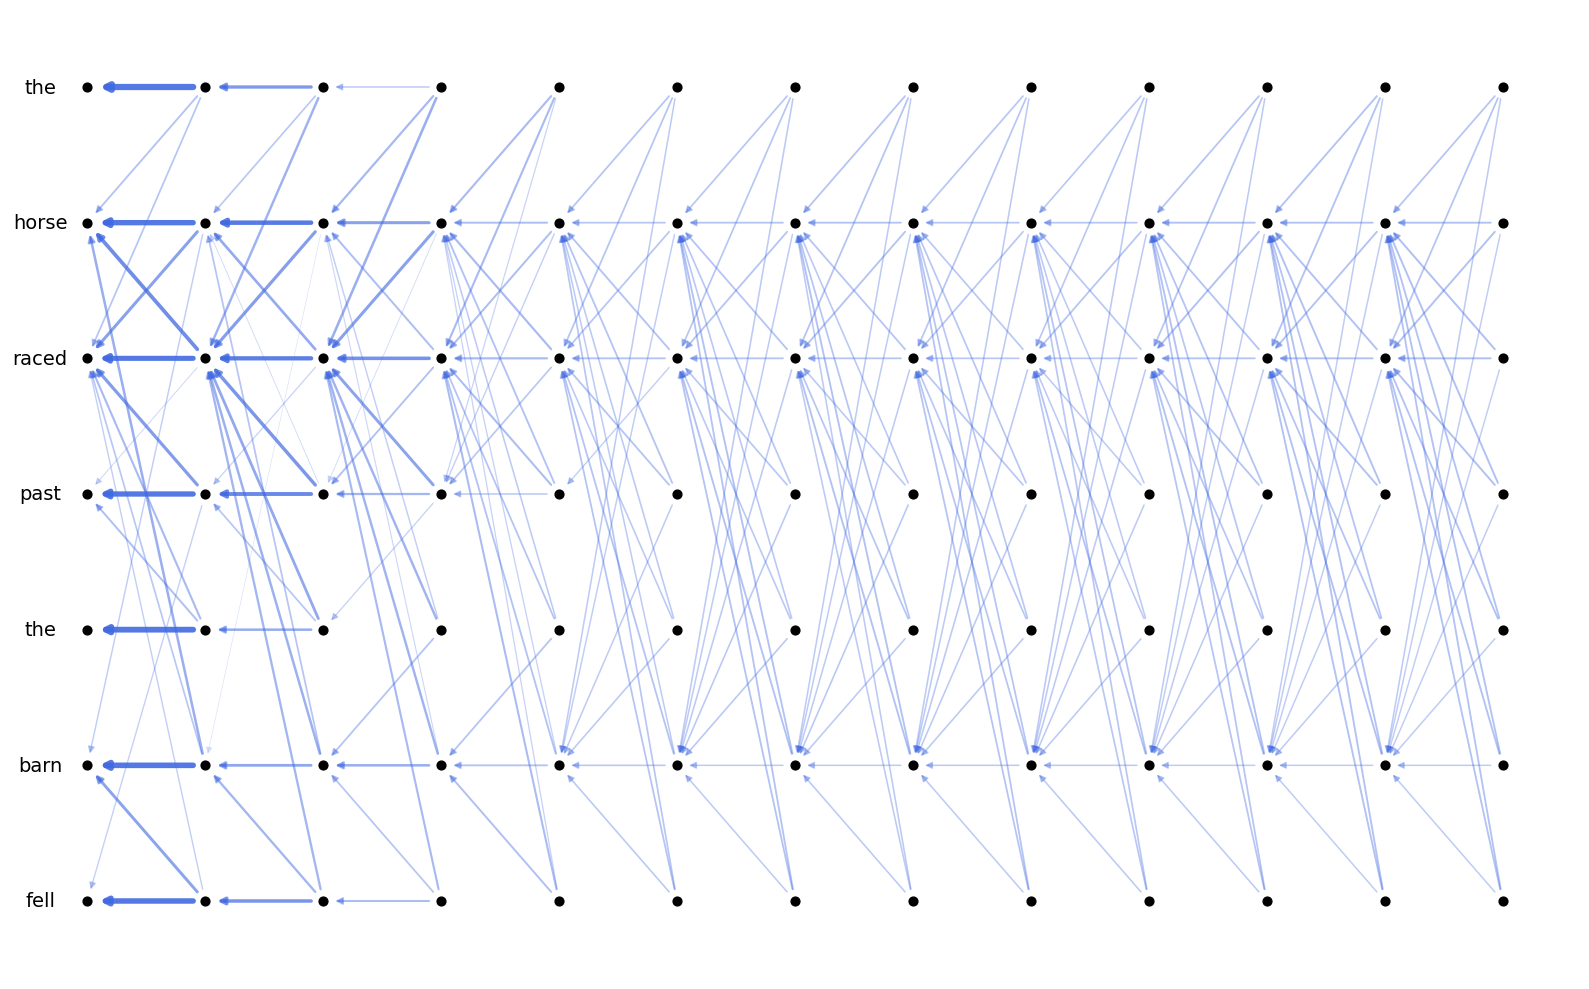

In [10]:
last_layer_name = f'L{attentions_mat.shape[0]}' # Descobre automaticamente se é L6, L12 ou L24
output_nodes = []
input_nodes = []
for key in res_labels_to_index:
    if last_layer_name in key: # <-- AGORA É DINÂMICO
        output_nodes.append(key)
    if res_labels_to_index[key] < attentions_mat.shape[-1]:
        input_nodes.append(key)

flow_values = compute_flows(res_G, res_labels_to_index, input_nodes, length=attentions_mat.shape[-1])

flow_G = draw_attention_graph(flow_values,labels_to_index, n_layers=attentions_mat.shape[0], length=attentions_mat.shape[-1])
plt.savefig('res_fat_bert.jpg', format='jpg', transparent=True, dpi=760)

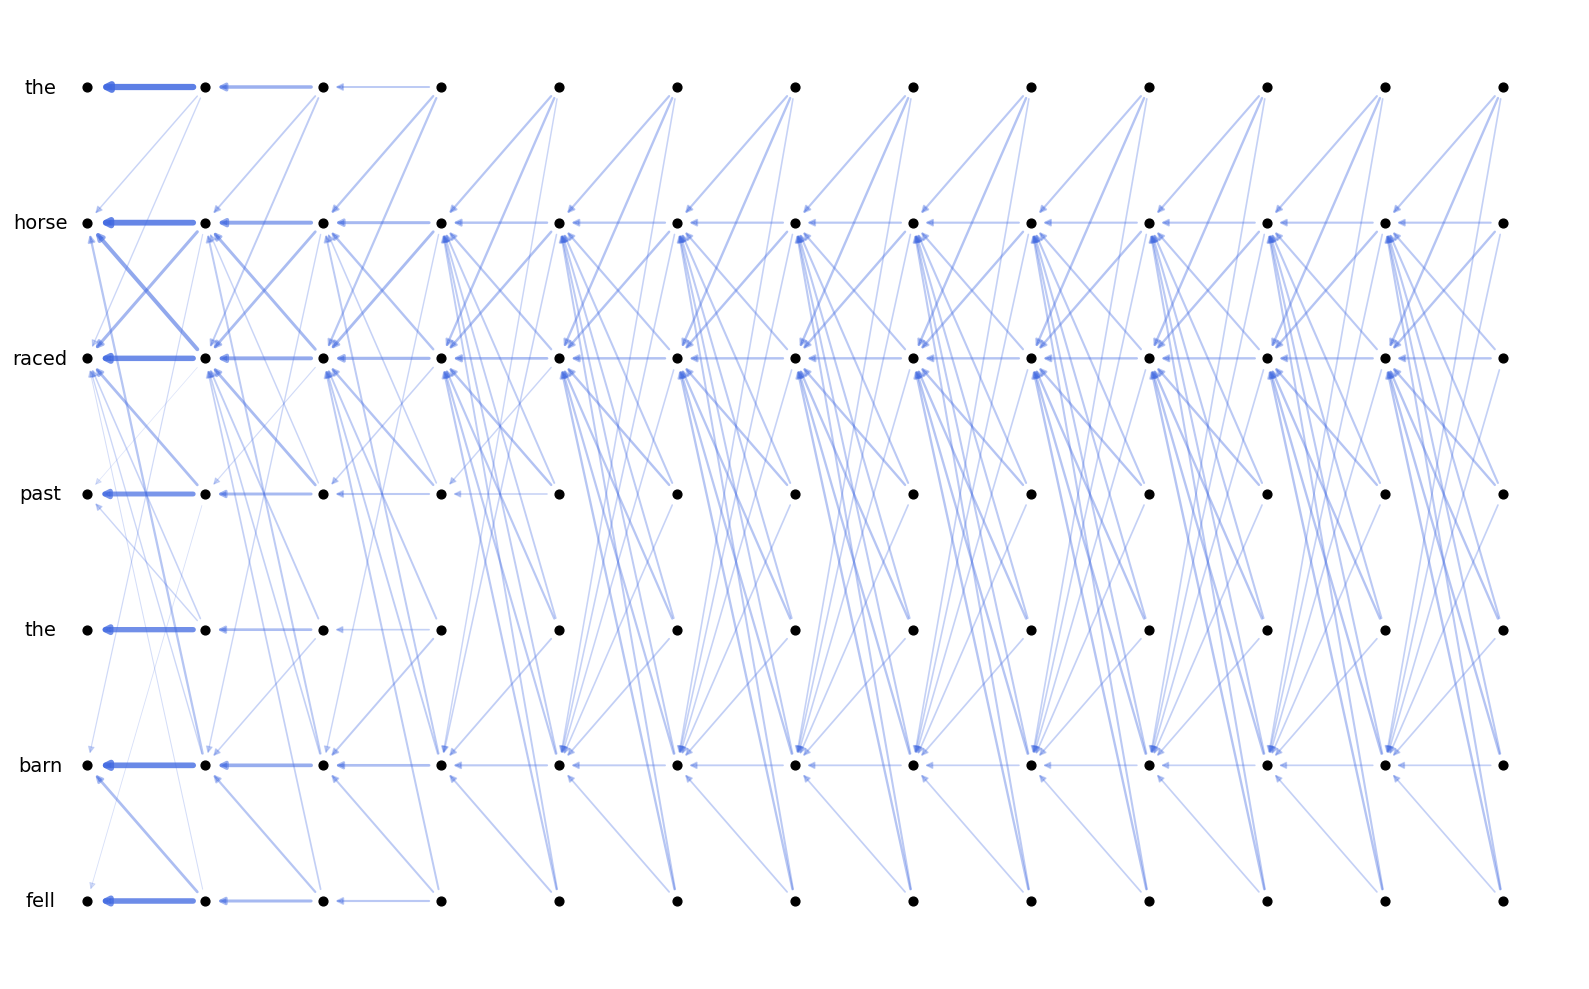

In [11]:
joint_attentions = compute_joint_attention(res_att_mat, add_residual=False)
joint_att_adjmat, joint_labels_to_index = get_adjmat(mat=joint_attentions, input_tokens=tokens)

G = draw_attention_graph(joint_att_adjmat,joint_labels_to_index, n_layers=joint_attentions.shape[0], length=joint_attentions.shape[-1])
plt.savefig('res_jat_bert.jpg', format='jpg', transparent=True, dpi=760)

In [12]:
import tensorflow as tf
from transformers import (
    glue_convert_examples_to_features,
    TFBertForSequenceClassification
)
import tensorflow_datasets as tfds

In [13]:
data = tfds.load('glue/mrpc')

# Prepare dataset for GLUE as a tf.data.Dataset instance
train_dataset = glue_convert_examples_to_features(data['train'], tokenizer, max_length=128, task='mrpc')
valid_dataset = glue_convert_examples_to_features(data['validation'], tokenizer, max_length=128, task='mrpc')
train_dataset = train_dataset.shuffle(100).batch(32).repeat(10)
valid_dataset = valid_dataset.batch(64)

valid_iter = iter(valid_dataset)

c:\int_Att\venv\lib\site-packages\transformers\data\processors\glue.py:66: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)
c:\int_Att\venv\lib\site-packages\transformers\data\processors\glue.py:174: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


In [14]:
data = tfds.load('glue/sst2')

# Prepare dataset for GLUE as a tf.data.Dataset instance
train_dataset = glue_convert_examples_to_features(data['train'], tokenizer, max_length=128, task='sst-2')
valid_dataset = glue_convert_examples_to_features(data['validation'], tokenizer, max_length=128, task='sst-2')
train_dataset = train_dataset.shuffle(100).batch(32).repeat(10)
valid_dataset = valid_dataset.batch(64)

valid_iter = iter(valid_dataset)

c:\int_Att\venv\lib\site-packages\transformers\data\processors\glue.py:330: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


In [15]:
x,y = valid_iter.next()
print(x['input_ids'][0])


tf.Tensor(
[  101  1037  3643  3238 25358  2666  6643 11219  2000  4013  3455  2104
 15773  2011  1996  6452  1012   102     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0], shape=(128,), dtype=int32)


In [16]:
# Baixando um BERT já treinado perfeitamente na tarefa MRPC direto do Hugging Face!
pytorch_model = BertForSequenceClassification.from_pretrained(
    'textattack/bert-base-uncased-MRPC', 
    output_hidden_states=True,
    output_attentions=True
)

In [17]:
# Quickly test a few predictions - MRPC is a paraphrasing task, let's see if our model learned the task
sentence_0 = "This research was consistent with his findings."
sentence_1 = "His findings were compatible with this research."
sentence_2 = "His findings were not consistent with this research."
inputs_1 = tokenizer.encode_plus(sentence_0, sentence_1, add_special_tokens=True, return_tensors='pt')
inputs_2 = tokenizer.encode_plus(sentence_0, sentence_2, add_special_tokens=True, return_tensors='pt')

pred_1 = pytorch_model(inputs_1['input_ids'], token_type_ids=inputs_1['token_type_ids'])[0].argmax().item()
pred_2 = pytorch_model(inputs_2['input_ids'], token_type_ids=inputs_2['token_type_ids'])[0].argmax().item()

print("sentence_1 is", "a paraphrase" if pred_1 else "not a paraphrase", "of sentence_0")
print("sentence_2 is", "a paraphrase" if pred_2 else "not a paraphrase", "of sentence_0")

sentence_1 is a paraphrase of sentence_0
sentence_2 is a paraphrase of sentence_0


In [18]:
sentence_0 = "I saw it peeking through the window"
sentence_1 = "I was peeking when I saw it"

inputs_1 = tokenizer.encode_plus(sentence_0, sentence_1, add_special_tokens=True, return_tensors='pt')
outputs_1 = pytorch_model(inputs_1['input_ids'], token_type_ids=inputs_1['token_type_ids'])

pred_1 = outputs_1[0].argmax().item()
print("prediction:", bool(pred_1))

orig_tokens_1 = tokenizer.convert_ids_to_tokens(inputs_1['input_ids'][0])

special_tokens = [tokenizer.sep_token] 
remove_indices = [i for i, t in enumerate(orig_tokens_1) if t in special_tokens]

tokens_1 = [t for i, t in enumerate(orig_tokens_1) if i not in remove_indices]

all_hidden_states, all_attentions = outputs_1[-2:]
_attentions = [att.detach().numpy() for att in all_attentions]
attentions_mat = np.asarray(_attentions)[:,0] 

attentions_mat = np.delete(attentions_mat, remove_indices, axis=2)
attentions_mat = np.delete(attentions_mat, remove_indices, axis=3)


prediction: True


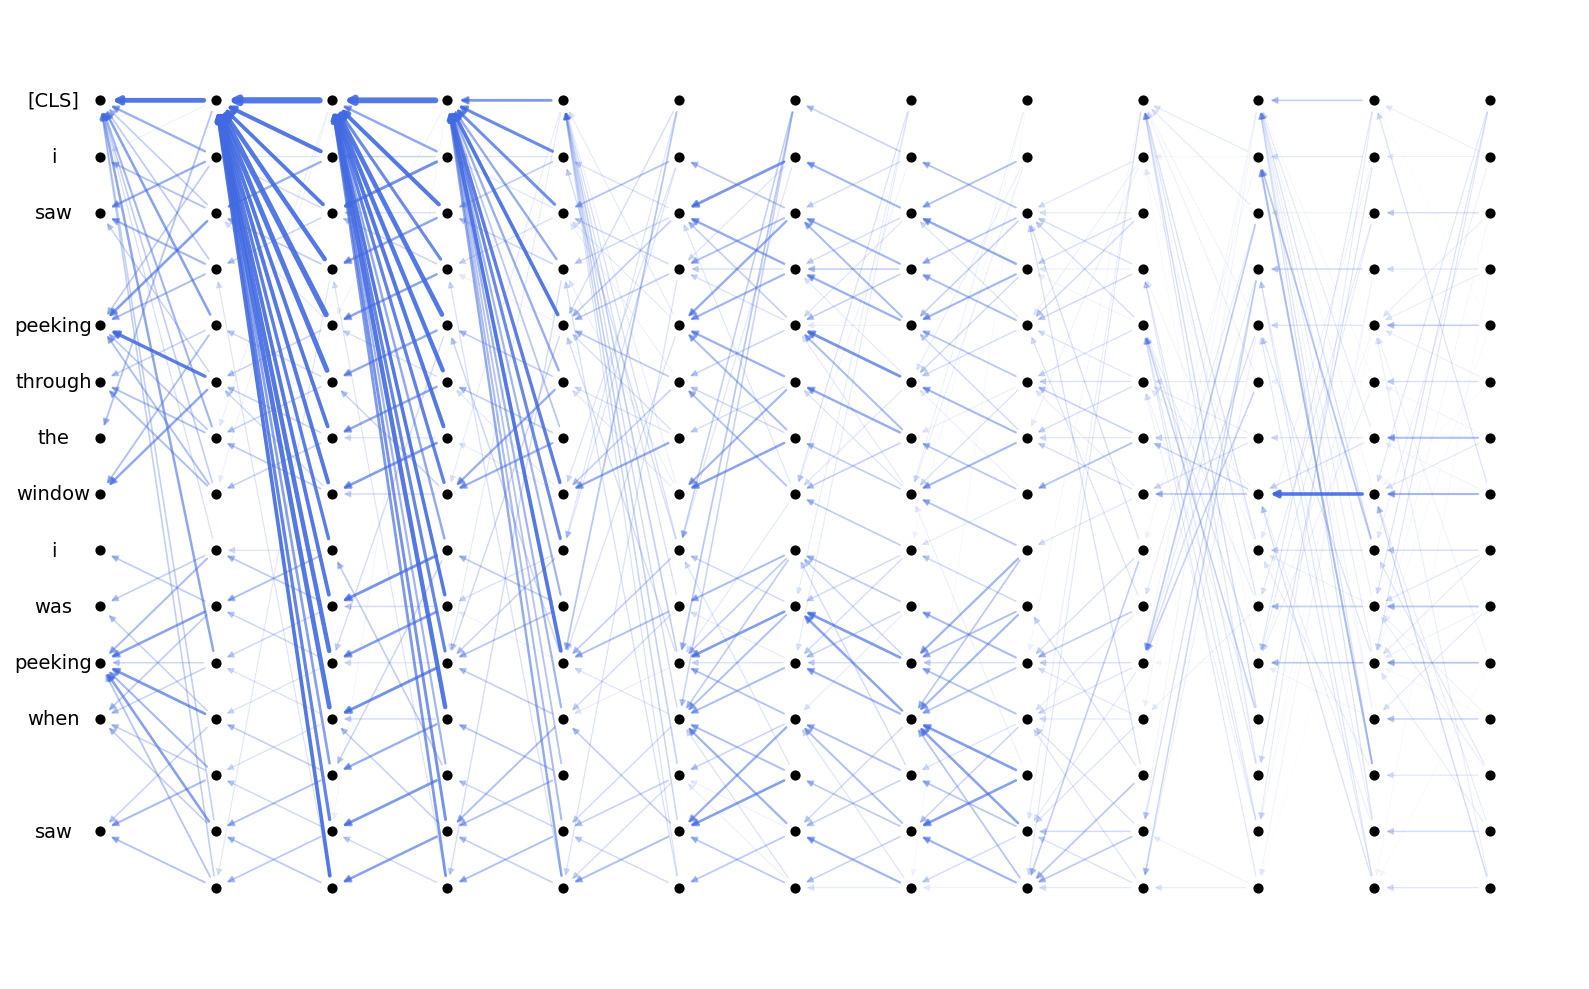

In [19]:
att_mat = attentions_mat.sum(axis=1)/8
adj_mat, labels_to_index = get_adjmat(mat=att_mat, input_tokens=tokens_1)

G = draw_attention_graph(adj_mat,labels_to_index, n_layers=attentions_mat.shape[0], length=attentions_mat.shape[-1])
plt.margins(0.06)
plt.savefig('rat_bert_mrpc.jpg', format='jpg', transparent=True, dpi=760)

In [20]:
att_mat[-1][0]

array([0.05051919, 0.04002951, 0.06495987, 0.04169333, 0.07088832,
       0.04665827, 0.03594775, 0.07832492, 0.06309562, 0.08827116,
       0.0818141 , 0.03318302, 0.04867791, 0.04380404, 0.04292729],
      dtype=float32)

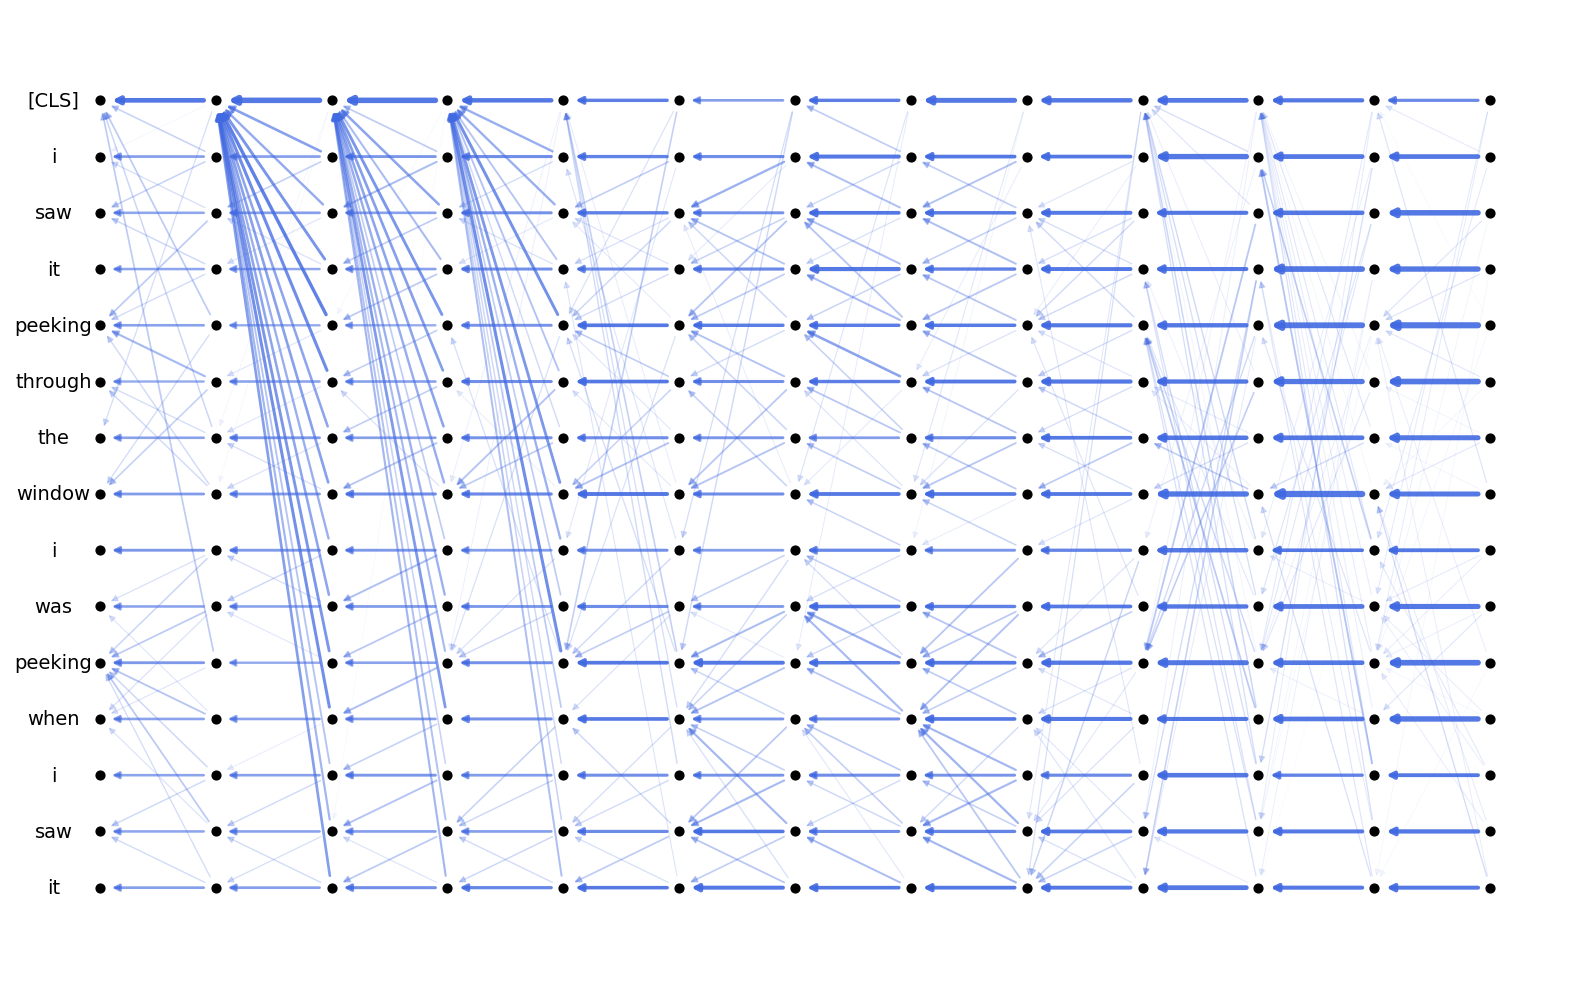

In [21]:
res_att_mat = attentions_mat.sum(axis=1)/12
res_att_mat = res_att_mat + (0.3* np.eye(res_att_mat.shape[1])[None,...])
res_att_mat = res_att_mat / res_att_mat.sum(axis=-1)[...,None]
 
res_adj_mat, res_labels_to_index = get_adjmat(mat=res_att_mat, input_tokens=tokens_1)

res_G = draw_attention_graph(res_adj_mat,res_labels_to_index, n_layers=res_att_mat.shape[0], length=res_att_mat.shape[-1])
plt.margins(0.06)
plt.savefig('res_rat_bert_mrpc.jpg', format='jpg', transparent=True, dpi=760)

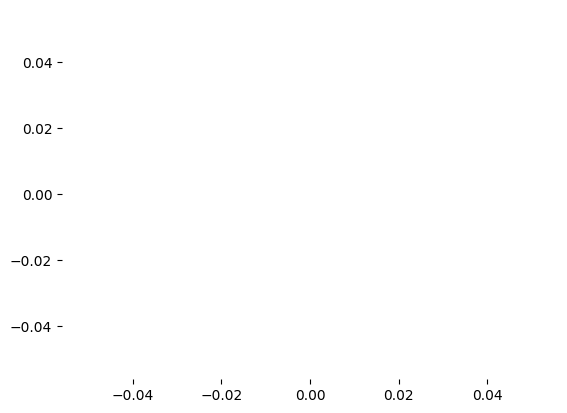

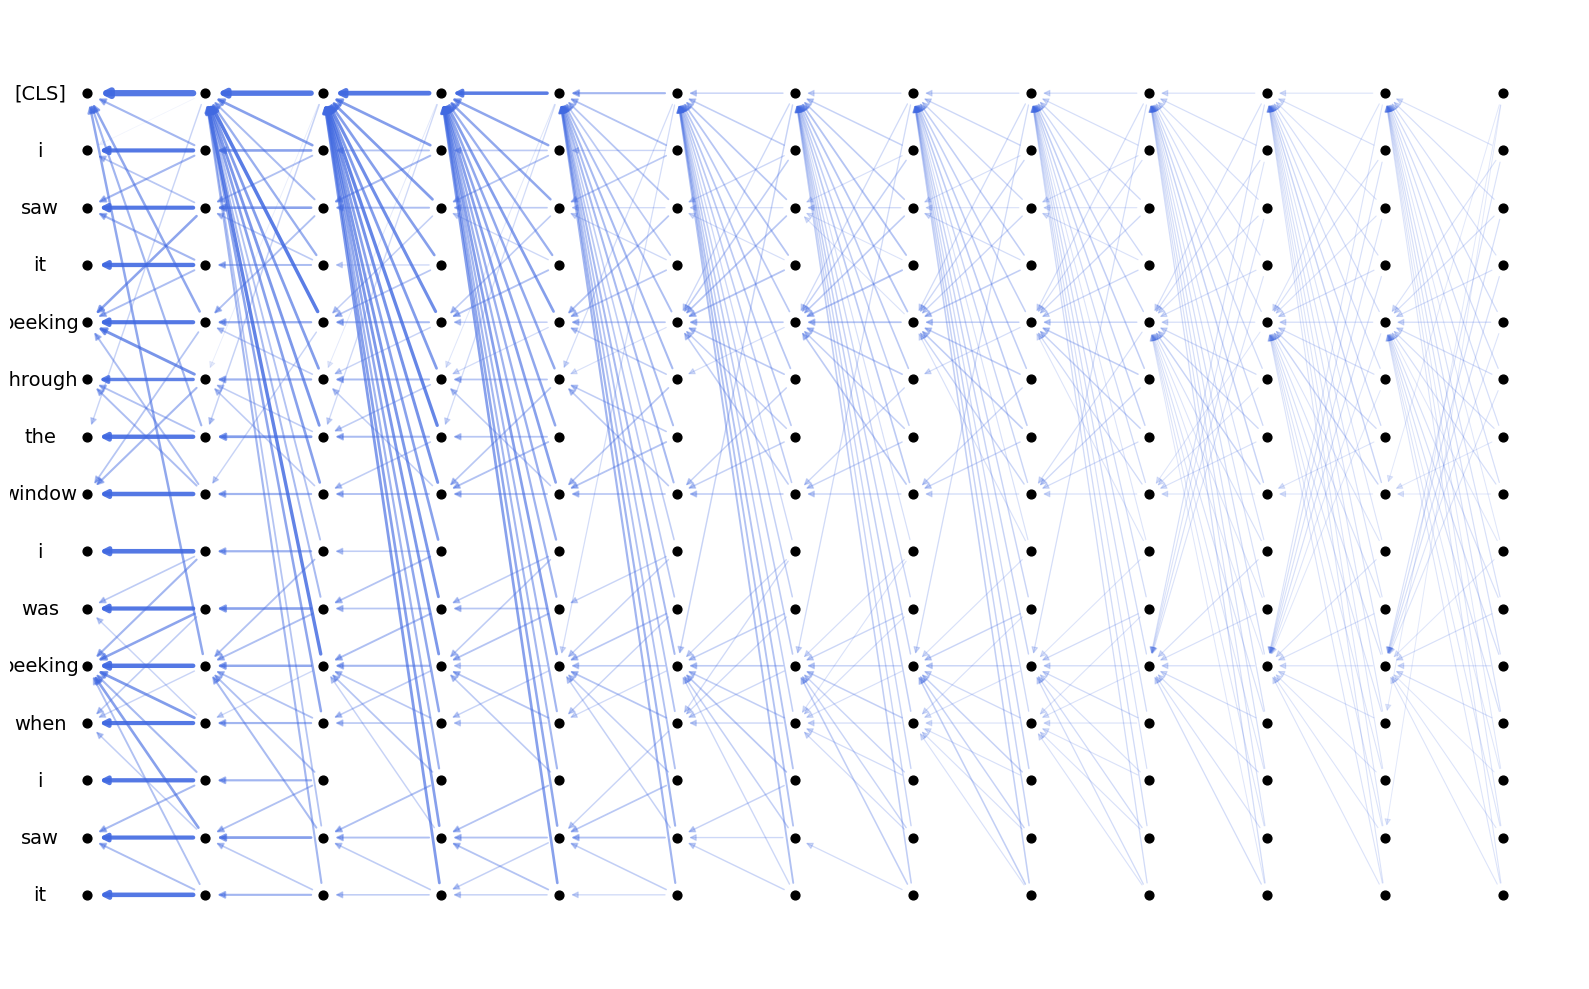

In [22]:
last_layer_name = f'L{attentions_mat.shape[0]}' # Descobre automaticamente se é L6, L12 ou L24
output_nodes = []
input_nodes = []
for key in res_labels_to_index:
    if last_layer_name in key: # <-- AGORA É DINÂMICO
        output_nodes.append(key)
    if res_labels_to_index[key] < attentions_mat.shape[-1]:
        input_nodes.append(key)

flow_values = compute_flows(res_G, res_labels_to_index, input_nodes, length=attentions_mat.shape[-1])
plt.margins(0.06)
flow_G = draw_attention_graph(flow_values,res_labels_to_index, n_layers=attentions_mat.shape[0], length=attentions_mat.shape[-1])
plt.savefig('res_fat_bert_mrpc.jpg', format='jpg', transparent=True, dpi=760)

In [23]:
l = 14
d = 12
flow_values[d*l:, (d-1)*l: d*l][0]

array([0.10981425, 0.06548765, 0.05281133, 0.07627974, 0.04358184,
       0.06237767, 0.10305473, 0.07349426, 0.03869774, 0.05509598,
       0.04091006, 0.        , 0.        , 0.        ])

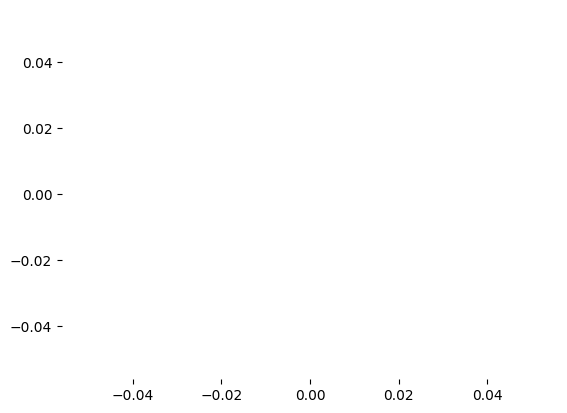

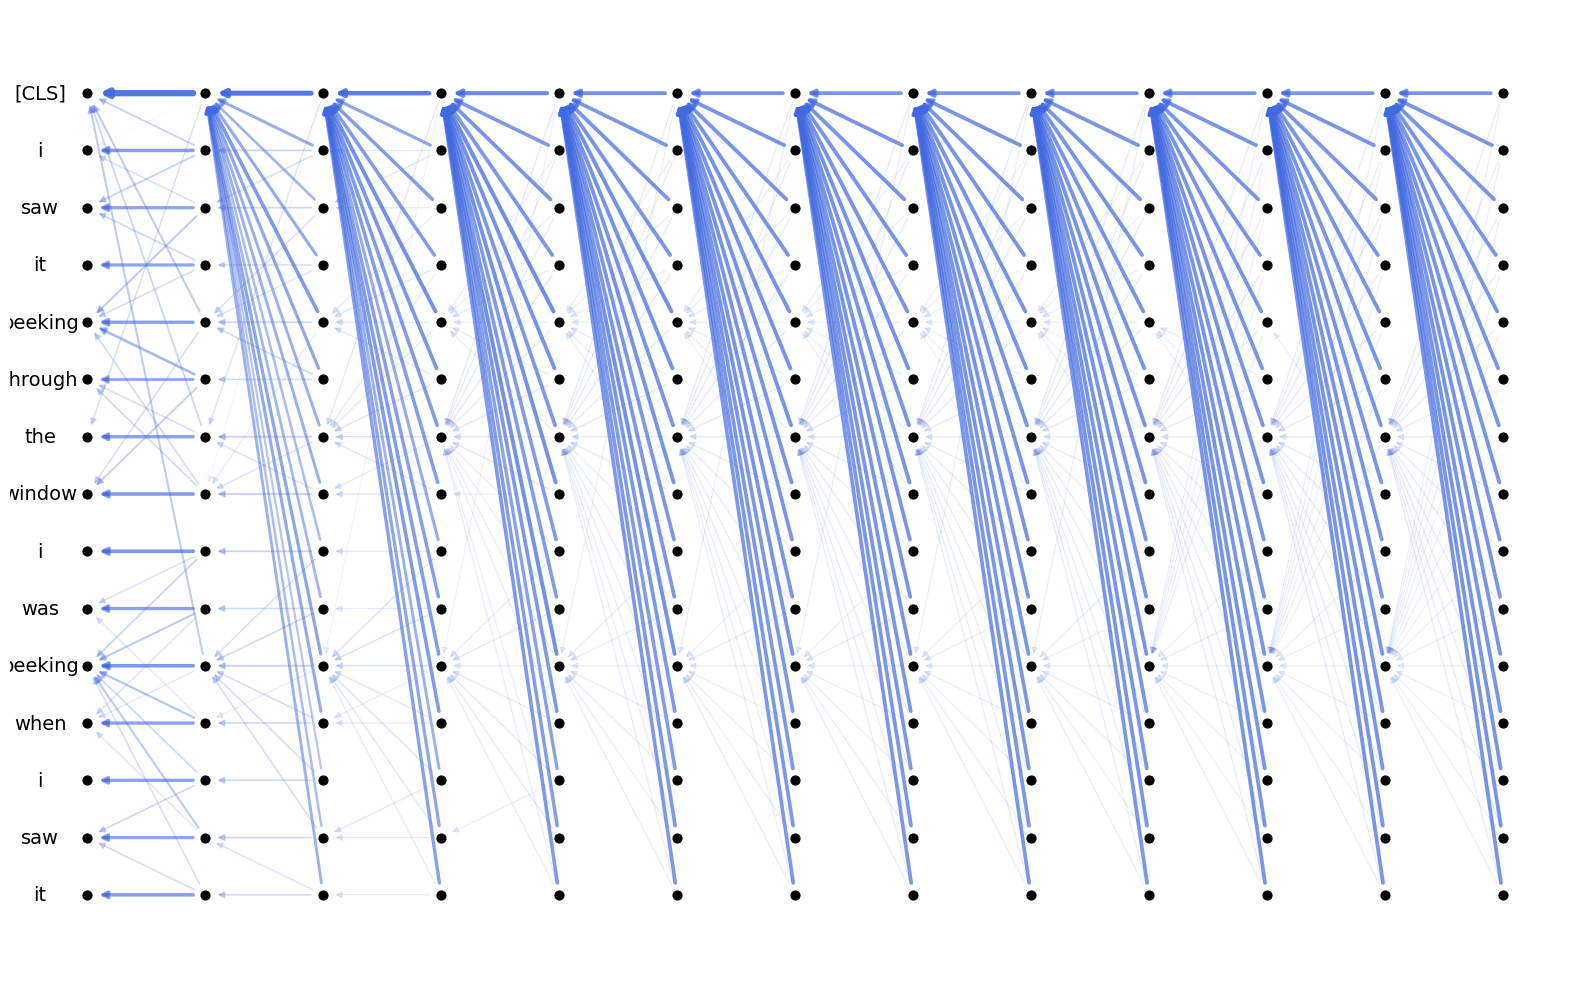

In [24]:
joint_attentions = compute_joint_attention(res_att_mat, add_residual=False)
joint_att_adjmat, joint_labels_to_index = get_adjmat(mat=joint_attentions, input_tokens=tokens_1)

plt.margins(0.06)
G = draw_attention_graph(joint_att_adjmat,joint_labels_to_index, n_layers=joint_attentions.shape[0], length=joint_attentions.shape[-1])
plt.savefig('res_jat_bert_mrpc.jpg', format='jpg', transparent=True, dpi=760)

In [25]:
joint_attentions[-1][0]

array([0.35203183, 0.04126695, 0.04508435, 0.03777228, 0.0587842 ,
       0.04334178, 0.07385772, 0.04915971, 0.03871182, 0.03466149,
       0.06250687, 0.04430984, 0.0376277 , 0.04349364, 0.03738982])

In [26]:
for x,y in zip(tokens_1, joint_attentions[-1][0]):
    print("("+x+","+str(y)+")")
    
','.join(tokens_1)

([CLS],0.3520318304091692)
(i,0.0412669465511596)
(saw,0.045084350130208846)
(it,0.03777228294147672)
(peeking,0.05878420246253593)
(through,0.043341784714015605)
(the,0.07385772075103549)
(window,0.04915970597213756)
(i,0.0387118248651888)
(was,0.034661491372365585)
(peeking,0.06250686642812357)
(when,0.044309837791831966)
(i,0.03762769786765742)
(saw,0.04349363668311222)
(it,0.03738982105998087)


'[CLS],i,saw,it,peeking,through,the,window,i,was,peeking,when,i,saw,it'

In [27]:
for x,y in zip(tokens_1, att_mat[-1][0]):
    print("("+x+","+str(y)+")")
    
','.join(tokens_1)

([CLS],0.050519194)
(i,0.040029515)
(saw,0.06495987)
(it,0.04169333)
(peeking,0.07088832)
(through,0.046658266)
(the,0.03594775)
(window,0.07832492)
(i,0.06309562)
(was,0.08827116)
(peeking,0.0818141)
(when,0.033183016)
(i,0.048677906)
(saw,0.04380404)
(it,0.042927295)


'[CLS],i,saw,it,peeking,through,the,window,i,was,peeking,when,i,saw,it'

In [28]:
l = 14
d = 12
for x,y in zip(tokens_1,flow_values[d*l:, (d-1)*l: d*l][0]):
    print("("+x+","+str(y)+")")
    
','.join(tokens_1)

([CLS],0.10981425225804786)
(i,0.06548765256576325)
(saw,0.05281132957406118)
(it,0.07627974091486628)
(peeking,0.043581843460123774)
(through,0.062377670775207485)
(the,0.1030547332073588)
(window,0.07349426218950397)
(i,0.03869774163228803)
(was,0.05509597879079344)
(peeking,0.04091006181433851)
(when,0.0)
(i,0.0)
(saw,0.0)


'[CLS],i,saw,it,peeking,through,the,window,i,was,peeking,when,i,saw,it'